In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
False


In [6]:
import pydicom
from pathlib import Path
from zipfile import ZipFile
import re
loc = Path("/home/rl2252/10/Bulk/Liver MRI/ShMOLLI/10")
subs = []
out_root = loc / "unzipped"
out_root.mkdir(parents=True, exist_ok=True)

for zp in sorted(loc.glob("*.zip")):
    m = re.match(r"(\d+)_20204_2_0\.zip$", zp.name)
    out_dir = out_root / zp.stem

    out_dir.mkdir(parents=True, exist_ok=True)
    with ZipFile(zp) as zf:
        zf.extractall(out_dir)

    if m:
        subs.append(m.group(1))

print(len(subs))

1659


In [4]:
from pathlib import Path
import re
import pydicom

subs = []
loc = Path("/home/rl2252/ShMOLLI_Data/10/Bulk/Liver MRI/ShMOLLI/10/unzipped")

for ent in Path(loc).iterdir():
    if not ent.is_dir():
        continue
    mtch = re.match('(\\d+)_20204_2_0', ent.name)
    if mtch:
        subs.append(mtch.group(1))

sub_dcms = {}

for i,sub in enumerate(subs):
    dcm_paths = []
    for ent in Path(f'{loc}/{sub}_20204_2_0').iterdir():
        if re.match('.*\\.dcm$', ent.name):
            dcm_paths.append(ent)
            
    dcms = []
    for path in dcm_paths:
        d = pydicom.dcmread(path)
        dcms.append(d)

    series_numbers = set()
    for dcm in dcms:
        series_numbers.add(int(dcm.SeriesNumber))
    series_numbers = sorted(list(series_numbers))

    first_dcms = []
    for dcm in dcms:
        if int(dcm.SeriesNumber) == series_numbers[0]:
            first_dcms.append(dcm)

    #first_dcms.sort(key=lambda dcm: int(dcm.InstanceNumber))
    first_dcms.sort(key=lambda dcm: int(dcm.ImageComments.split(' ')[1]))

    for dcm in first_dcms:
        print(dcm.InstanceNumber, dcm.ImageComments)

    sub_dcms[sub] = first_dcms

    # sub_dcms[sub] = []
    # for dcm in dcms:
    #     if int(dcm.SeriesNumber) == series_numbers[0]: # and int(dcm.InstanceNumber) == 1:
    #         sub_dcms[sub].append(dcm) #dcm.pixel_array

    # for dcm in sub_dcms[sub]:
    #     print(dcm.ImageComments)

print(sub)



1 TIeff 170 ms
6 TIeff 220 ms
7 TIeff 270 ms
2 TIeff 1167 ms
3 TIeff 2172 ms
4 TIeff 3167 ms
5 TIeff 4155 ms
1 TIeff 170 ms
6 TIeff 220 ms
7 TIeff 270 ms
2 TIeff 1330 ms
3 TIeff 2487 ms
4 TIeff 3650 ms
5 TIeff 4817 ms
1 TIeff 170 ms
6 TIeff 220 ms
7 TIeff 270 ms
2 TIeff 990 ms
3 TIeff 1803 ms
4 TIeff 2618 ms
5 TIeff 3440 ms
1 TIeff 170 ms
6 TIeff 220 ms
7 TIeff 270 ms
2 TIeff 885 ms
3 TIeff 1598 ms
4 TIeff 2305 ms
5 TIeff 3005 ms
1 TIeff 170 ms
6 TIeff 220 ms
7 TIeff 270 ms
2 TIeff 1400 ms
3 TIeff 2658 ms
4 TIeff 3873 ms
5 TIeff 5075 ms
1 TIeff 170 ms
6 TIeff 220 ms
7 TIeff 270 ms
2 TIeff 990 ms
3 TIeff 2635 ms
4 TIeff 3435 ms
5 TIeff 4227 ms
1 TIeff 170 ms
6 TIeff 220 ms
7 TIeff 270 ms
2 TIeff 1240 ms
3 TIeff 2310 ms
4 TIeff 3372 ms
5 TIeff 4415 ms
1 TIeff 170 ms
6 TIeff 220 ms
7 TIeff 270 ms
2 TIeff 1087 ms
3 TIeff 2005 ms
4 TIeff 2917 ms
5 TIeff 3840 ms
1 TIeff 170 ms
6 TIeff 220 ms
7 TIeff 270 ms
2 TIeff 1110 ms
3 TIeff 2073 ms
4 TIeff 3023 ms
5 TIeff 3973 ms
1 TIeff 170 ms
6 TIeff

InvalidDicomError: File is missing DICOM File Meta Information header or the 'DICM' prefix is missing from the header. Use force=True to force reading.

In [5]:
print(len(sub_dcms))

1161


In [6]:
import pickle

with open("/vast/palmer/scratch/zhao_yize/rl2252/LiverShMOLLI_10_dcms.pkl", "wb") as f:
    pickle.dump(sub_dcms, f)

print(len(sub_dcms))

1161


In [1]:
import pickle

with open("/vast/palmer/scratch/zhao_yize/rl2252/LiverShMOLLI_10_dcms.pkl", "rb") as f:
    sub_dcms = pickle.load(f)


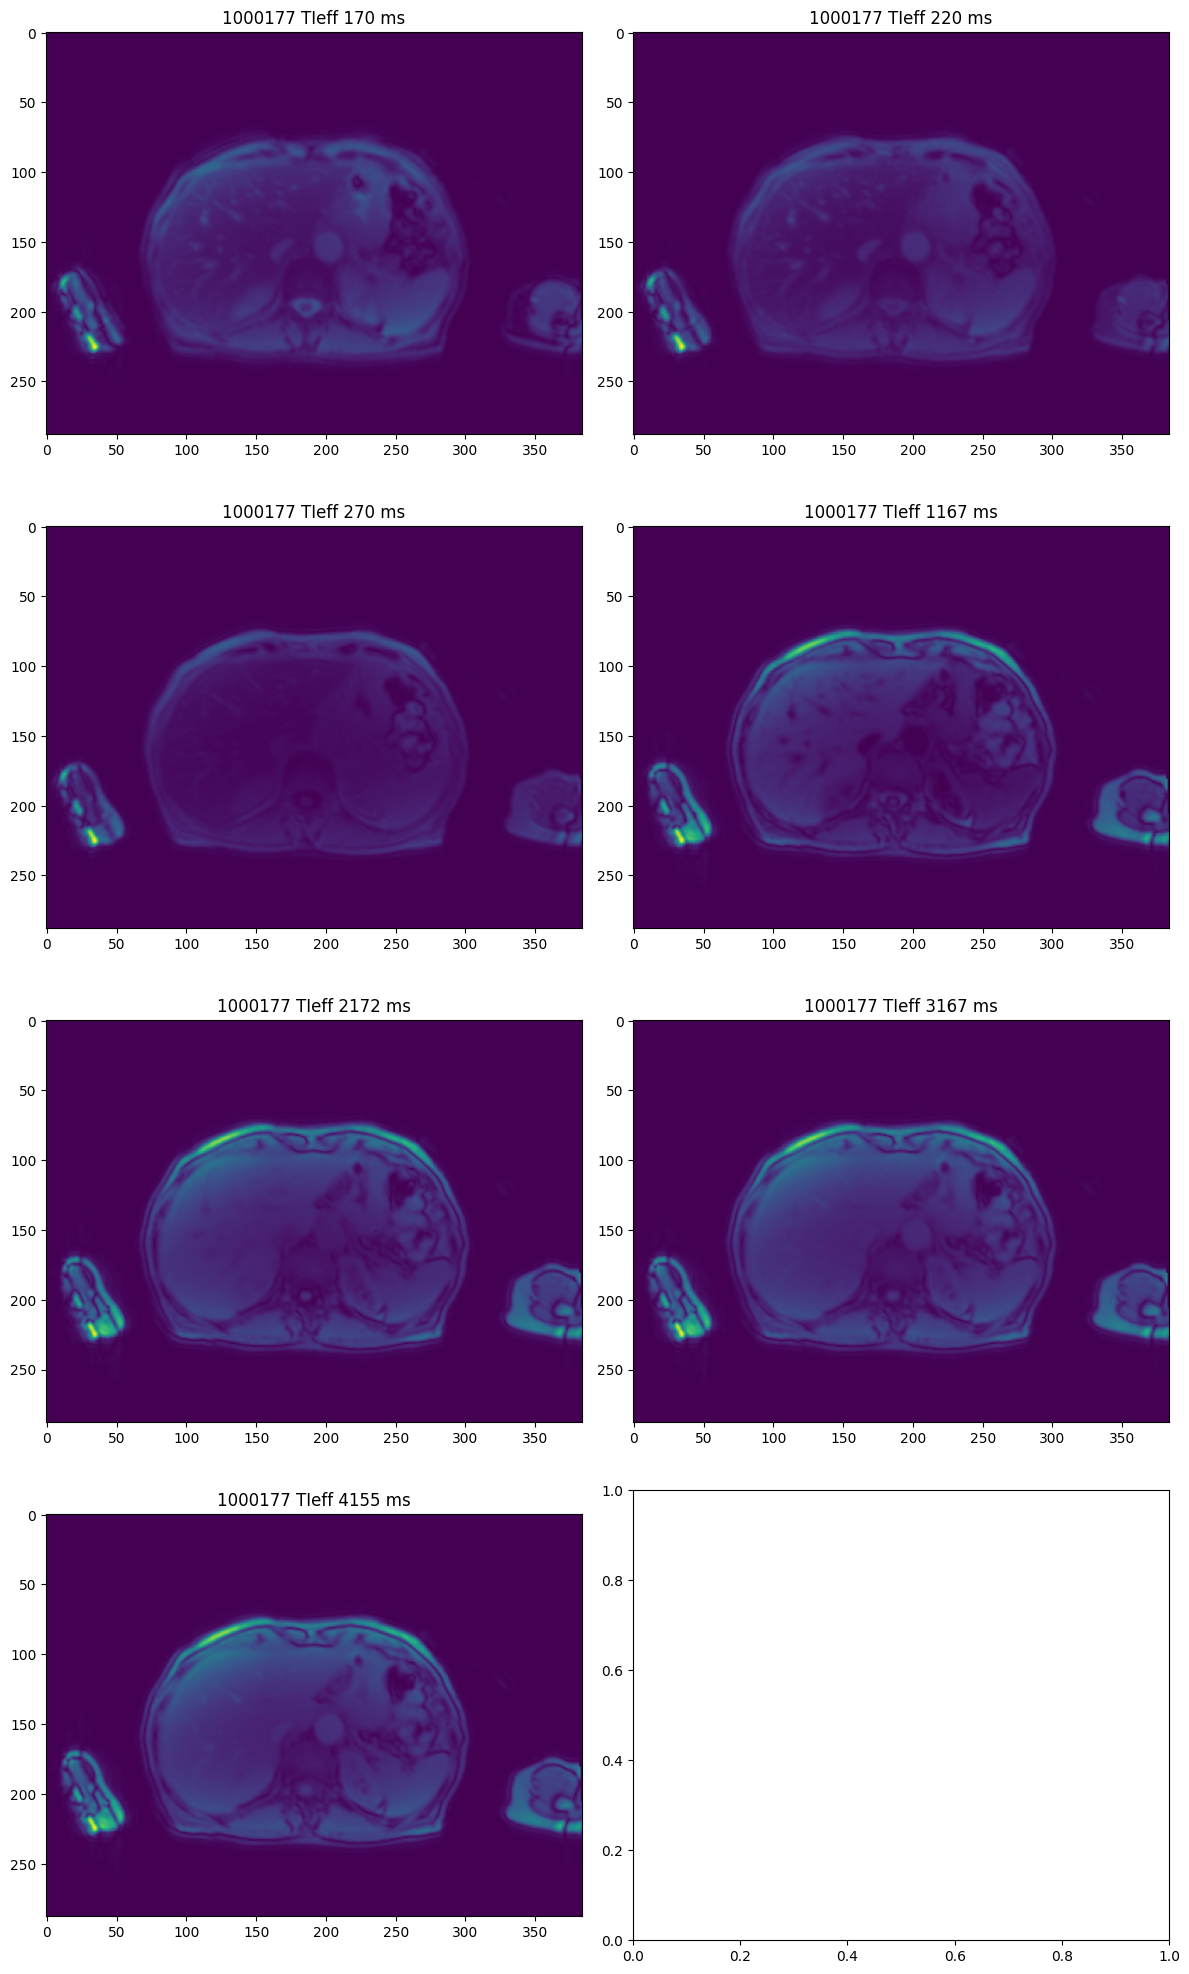

In [2]:
import matplotlib.pyplot as plt
import math 

for sub, dcms in sub_dcms.items():
    fig, ax = plt.subplots(4,2,figsize=(12,20))
    for i,dcm in enumerate(dcms):
        r = math.floor(i/2)
        c = i % 2
        ax[r,c].imshow(dcm.pixel_array)
        ax[r,c].set_title(f"{sub} {dcm.ImageComments}")
        
    plt.tight_layout()
    plt.show()
    
    break

    


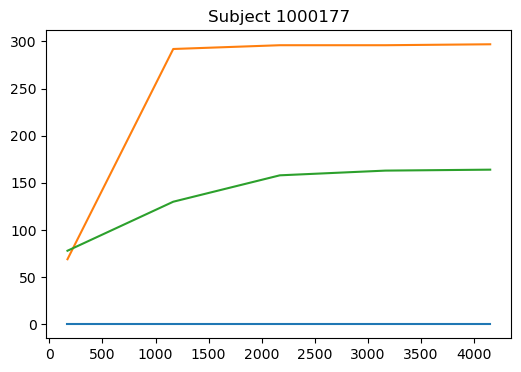

In [2]:
pixels = [(100, 60), (100,100), (100, 150)]

for sub, dcms in sub_dcms.items():
    series = [[] for _ in pixels]
    times = []
    dcms = sub_dcms[sub]
    for j,dcm in enumerate(dcms):
        if j == 1 or j == 2:
            continue
        times.append(int(dcm.ImageComments.split(' ')[1]))
        for i,px in enumerate(pixels):
            val = dcm.pixel_array[px[0], px[1]]
            series[i].append(val)

    plt.figure(figsize=(6,4))
    for i in range(len(pixels)):
        plt.plot(times, series[i])
    plt.title(f"Subject {sub}")
    plt.show()

    break
    

In [ ]:
import torch
import numpy as np
import pickle
from tqdm import tqdm

# choose batch size
batch_id = 1      
batch_size = 400 
prefix = "AllSubject_T1_maps_batch"  

device = "cuda" if torch.cuda.is_available() else "cpu"

all_subs = sorted(sub_dcms.keys())
start = batch_id * batch_size
end   = min(start + batch_size, len(all_subs))
batch_subs = all_subs[start:end]
print(f"Total subjects: {len(all_subs)} | This batch: {start}..{end-1} ({len(batch_subs)})")

AllSubject_T1_maps = {}

# load existing batch file if present
out_path = f"/vast/palmer/scratch/zhao_yize/rl2252/AllSubject_T1_maps_batch{batch_id}.pkl"

try:
    with open(out_path, "rb") as f:
        AllSubject_T1_maps = pickle.load(f)
        print(f"[Resume] Loaded {len(AllSubject_T1_maps)} subjects from {out_path}")
except Exception:
    pass

nepochs = 2000
pperiod = 100
lr = 1.0

for sub in tqdm(batch_subs, desc=f"Batch {batch_id}"):
    if sub in AllSubject_T1_maps: 
        continue

    dcms = sub_dcms[sub]

    x_list, t_list = [], []
    for j, dcm in enumerate(dcms):
        if j in (1, 2): 
            continue
        arr = dcm.pixel_array.astype(np.float32)
        x_list.append(torch.from_numpy(arr).float().to(device))
        t_list.append(int(dcm.ImageComments.split()[1]))

    if not x_list or len(t_list) != len(x_list):
        print(f"[Skip] Subject {sub}: no usable frames")
        continue

    x = torch.stack(x_list)                         # [T,H,W]
    t = torch.tensor(t_list, dtype=torch.float32, device=device)  # [T]

    H, W = x.shape[1:]
    A  = torch.randn(H, W, device=device, requires_grad=True)
    B  = torch.randn(H, W, device=device, requires_grad=True)
    T1 = torch.full((H, W), 100.0, device=device, requires_grad=True)

    optim = torch.optim.Adam([A, B, T1], lr=lr)

    for e in range(nepochs):
        optim.zero_grad()
        arg = torch.einsum('t,xy->txy', t, -1.0/T1)
        val = A.unsqueeze(0) - B.unsqueeze(0) * torch.exp(arg)
        loss = torch.sum((val - x)**2)**0.5
        loss.backward()
        optim.step()

        if e % pperiod == 0 or e == nepochs - 1:
            tqdm.write(f"{sub} | epoch {e} | loss {float(loss):.4f}")

    t1 = T1.detach().cpu().numpy()
    AllSubject_T1_maps[sub] = t1

    with open(out_path, "wb") as f:
        pickle.dump(AllSubject_T1_maps, f)

print(f"Saved {len(AllSubject_T1_maps)} subjects to {out_path}")

In [ ]:
import matplotlib.pyplot as plt

for sub in sub_dcms:
    
    t1 = AllSubject_T1_maps[sub]
    plt.figure()
    plt.imshow(t1)
    plt.colorbar()
    plt.title(f"Subject {sub} T1")
    plt.show()
    break